In [1]:
import random as rd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import statistics as stat
import math
import scipy.stats as st

In [10]:
N=200
N1 = sum(np.random.randint(0,2,size = N) == 0)
N2 = N-N1

mean1 = np.array([2.5,2.5])
cov1 = np.array([[2,-0.8],[-0.8,2]])
X1 = np.random.multivariate_normal(mean1, cov1, N1)
label1 = 1

mean2 = np.array([0,0])
cov2 = np.array([[1,0],[0,1]])
N2 = 1000
X2 = np.random.multivariate_normal(mean2, cov2, N2)
label2 = 0

x1,x2 = [],[]
for i in range(N1):
    x1 += [list(X1[i,]) + [label1]]
for i in range(N2):
    x2 += [list(X2[i,]) + [label2]]
X = np.array(x1+x2)



### Grid of size  15*15

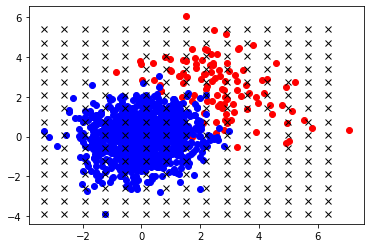

In [11]:
x1_min, x1_max=min(X[:,0]), max(X[:,0])
x2_min, x2_max=min(X[:,1]), max(X[:,1])
Neval=15;h1=(x1_max-x1_min)/Neval;h2=(x2_max-x2_min)/Neval
x1Eval, x2Eval=np.meshgrid(np.arange(x1_min, x1_max, h1), np.arange(x2_min, x2_max, h2));
plt.plot(X1[:,0],X1[:,1],'ro')
plt.plot(X2[:,0],X2[:,1],'bo')
plt.plot(x1Eval,x2Eval,'kx')
plt.show()

### Random Forest

#### Model Calibration on train set

In [17]:
#Random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
#tree = tree.DecisionTreeClassifier()
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =  train_test_split(X[:,0:2], 
                                                     X[:,2], 
                                                     test_size=1/3)

RF = RandomForestClassifier(max_depth=2, random_state=0, oob_score = True)
RFfit = RF.fit(X_train, y_train);

In [13]:
score=RF.score;
OOB=RF.oob_score_
IF=RF.feature_importances_

In [25]:
perf = {'train_accuracy' : score(X_train,y_train),
       'test_accuracy' : score(X_test, y_test), 
       'OOB_score' : OOB,
       'Features_importance' : IF}
perf

{'train_accuracy': 0.9878213802435724,
 'test_accuracy': 0.9756756756756757,
 'OOB_score': 0.9774571686203787,
 'Features_importance': array([0.51108836, 0.48891164])}

#### map

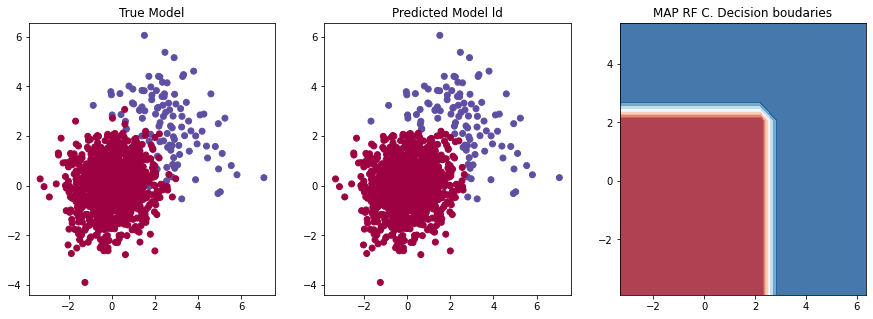

In [41]:
plt.figure(figsize=(15,5))
plt.subplot(132)
plt.scatter(X[:,0],X[:,1],c = RFfit.predict(X[:,0:2]),cmap = 'Spectral')
plt.title('Predicted Model ld')
plt.subplot(131)
plt.scatter(X[:,0],X[:,1],c = X[:,2],cmap = 'Spectral')
plt.title('True Model')
ax = plt.subplot(133)
ax.set_title('MAP RF C. Decision boudaries')
tt = np.array(list(zip(list(x1Eval.flat),list(x2Eval.flat))))
Z = RFfit.predict(tt)
Z = Z.reshape(x1Eval.shape)
cm = plt.cm.RdBu
ax.contourf(x1Eval, x2Eval, Z, cmap=cm, alpha=.8);
#ax.scatter(x1Eval,x2Eval,c='gray',marker='x')
plt.show()

### ADABOOST

##### Overall data

In [32]:
##Boosting
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
Ab = AdaBoostClassifier(n_estimators=100, random_state=0)
Abfit=Ab.fit(X[:,0:2], X[:,2])
y_pred=Abfit.predict(X[:,0:2]);
E_all=(X[:,2] != y_pred).sum()/len(X[:,2])
print("Boost Error on the complete training set %5.2f->",E_all)

Boost Error on the complete training set %5.2f-> 0.0


##### Separating train and test

In [38]:
#### splitting data
X_train, X_test, y_train, y_test =  train_test_split(X[:,0:2], 
                                                     X[:,2], 
                                                     test_size=1/3)
#### Training data
Ab = AdaBoostClassifier(n_estimators=100, random_state=0)
Abfit=Ab.fit(X_train, y_train)
y_pred_train=Abfit.predict(X_train);
E_train=(y_train != y_pred_train).sum()/len(y_train)
print("Boost Error on the complete training set %5.2f->",E_train)

#### prediction on test data
y_pred_test=Abfit.predict(X_test);
E_test=(y_test != y_pred_test).sum()/len(y_test)
print("Boost Error on the complete training set %5.2f->",E_test)

Boost Error on the complete training set %5.2f-> 0.0
Boost Error on the complete training set %5.2f-> 0.01891891891891892


#### map ADABOOST

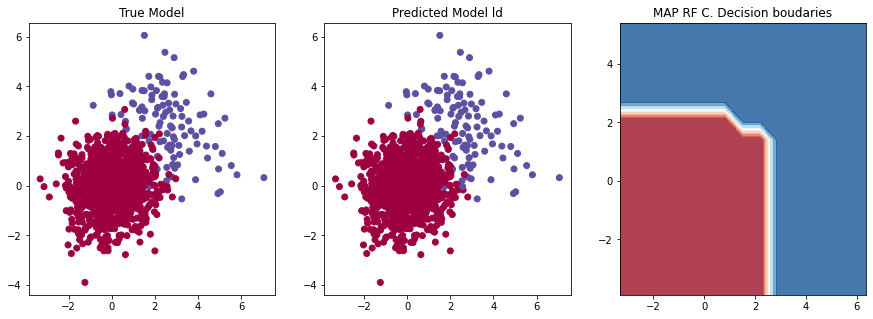

In [40]:
plt.figure(figsize=(15,5))
plt.subplot(132)
plt.scatter(X[:,0],X[:,1],c = Abfit.predict(X[:,0:2]),cmap = 'Spectral')
plt.title('Predicted Model ld')
plt.subplot(131)
plt.scatter(X[:,0],X[:,1],c = X[:,2],cmap = 'Spectral')
plt.title('True Model')
ax = plt.subplot(133)
ax.set_title('MAP ADABOOST C. Decision boudaries')
tt = np.array(list(zip(list(x1Eval.flat),list(x2Eval.flat))))
Z = Abfit.predict(tt)
Z = Z.reshape(x1Eval.shape)
cm = plt.cm.RdBu
ax.contourf(x1Eval, x2Eval, Z, cmap=cm, alpha=.8);
#ax.scatter(x1Eval,x2Eval,c='gray',marker='x')
plt.show()

#### Structure of the successive Adaboost trees

In [42]:
import matplotlib.pyplot as plt
Ad = AdaBoostClassifier(n_estimators=200, random_state=0)
Ad.fit(X[:,0:2], X[:,2])

AdaBoostClassifier(n_estimators=200, random_state=0)

Text(0.5, 0, 'Number of Trees')

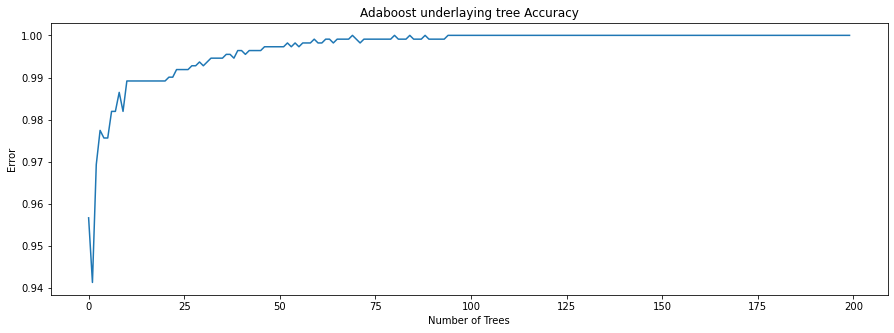

In [44]:
Ad_seq_errors = []
for Ad_train_predict in Ad.staged_predict(X[:,0:2]):
    Ad_seq_errors.append(metrics.accuracy_score(Ad_train_predict, X[:,2]))
plt.figure(figsize=(15, 5))
plt.plot(Ad_seq_errors); plt.title('Adaboost underlaying tree Accuracy')
plt.ylabel('Error'); plt.xlabel('Number of Trees')

### Gradient Boosting

#### Model calibration

In [45]:
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
GB = GradientBoostingClassifier(random_state=0)
GBfit=GB.fit(X[:,0:2], X[:,2])
y_pred=GBfit.predict(X[:,0:2])
E_all=(X[:,2] != y_pred).sum()/len(X[:,2])
print("Gradient Boosting Error on the complete training set %5.2f->",E_all)

Gradient Boosting Error on the complete training set %5.2f-> 0.0018034265103697023


In [47]:
#### splitting data
X_train, X_test, y_train, y_test =  train_test_split(X[:,0:2], 
                                                     X[:,2], 
                                                     test_size=1/3)
#### Training data
GB = GradientBoostingClassifier(random_state=0)
GBfit=GB.fit(X_train, y_train)
y_pred_train=GBfit.predict(X_train);
E_train=(y_train != y_pred_train).sum()/len(y_train)
print("Boost Error on the complete training set %5.2f->",E_train)

#### prediction on test data
y_pred_test=GBfit.predict(X_test);
E_test=(y_test != y_pred_test).sum()/len(y_test)
print("Boost Error on the complete training set %5.2f->",E_test)

Boost Error on the complete training set %5.2f-> 0.0
Boost Error on the complete training set %5.2f-> 0.016216216216216217


#### map Gradient Boosting

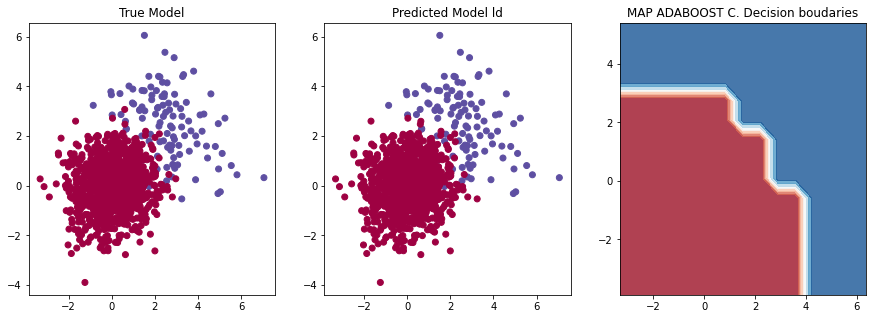

In [48]:
plt.figure(figsize=(15,5))
plt.subplot(132)
plt.scatter(X[:,0],X[:,1],c = GBfit.predict(X[:,0:2]),cmap = 'Spectral')
plt.title('Predicted Model ld')
plt.subplot(131)
plt.scatter(X[:,0],X[:,1],c = X[:,2],cmap = 'Spectral')
plt.title('True Model')
ax = plt.subplot(133)
ax.set_title('MAP ADABOOST C. Decision boudaries')
tt = np.array(list(zip(list(x1Eval.flat),list(x2Eval.flat))))
Z = GBfit.predict(tt)
Z = Z.reshape(x1Eval.shape)
cm = plt.cm.RdBu
ax.contourf(x1Eval, x2Eval, Z, cmap=cm, alpha=.8);
#ax.scatter(x1Eval,x2Eval,c='gray',marker='x')
plt.show()

#### Structure of the successive Adaboost trees

In [51]:
import matplotlib.pyplot as plt
GB = GradientBoostingClassifier(random_state=0)
GB.fit(X[:,0:2], X[:,2])

GradientBoostingClassifier(random_state=0)

Text(0.5, 0, 'Number of Trees')

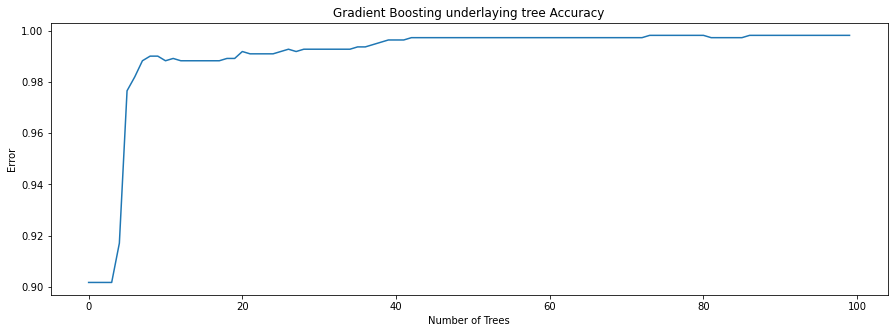

In [53]:
GB_seq_errors = []
for GB_train_predict in GB.staged_predict(X[:,0:2]):
    GB_seq_errors.append(metrics.accuracy_score(GB_train_predict, X[:,2]))

plt.figure(figsize=(15, 5))
plt.plot(GB_seq_errors); plt.title('Gradient Boosting underlaying tree Accuracy')
plt.ylabel('Error'); plt.xlabel('Number of Trees')

#### Stacking

In [63]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# get a stacking ensemble of models
def stack_model():
    # define the base models
    level0 = list()
    level0.append(('bayes', GaussianNB()))
    level0.append(('lda', LinearDiscriminantAnalysis(n_components=1)))
    level0.append(('qda', QuadraticDiscriminantAnalysis()))
    level0.append(('knn', KNeighborsClassifier(n_neighbors=5)))
    level0.append(('logreg', LogisticRegression(C=1e5)))
    level0.append(('Tree', DecisionTreeClassifier()))

    # define meta learner model
    level1 = DecisionTreeClassifier(random_state=0)
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

In [64]:
stack = stack_model()
stackfit = stack.fit(X[:,0:2], X[:,2])
y_pred=stackfit.predict(X[:,0:2]);
E_all=(X[:,2] != y_pred).sum()/len(X[:,2])
print("Stack Error on the complete training set %5.2f->",E_all)

Stack Error on the complete training set %5.2f-> 0.009017132551848512


In [65]:
#### splitting data
X_train, X_test, y_train, y_test =  train_test_split(X[:,0:2], 
                                                     X[:,2], 
                                                     test_size=1/3)
#### Training data
stack = stack_model()
stackfit=stack.fit(X_train, y_train)
y_pred_train=stackfit.predict(X_train);
E_train=(y_train != y_pred_train).sum()/len(y_train)
print("Stack Error on the complete training set %5.2f->",E_train)

#### prediction on test data
y_pred_test=stackfit.predict(X_test);
E_test=(y_test != y_pred_test).sum()/len(y_test)
print("Stack Error on the complete test set %5.2f->",E_test)

Stack Error on the complete training set %5.2f-> 0.008119079837618403
Stack Error on the complete test set %5.2f-> 0.03513513513513514


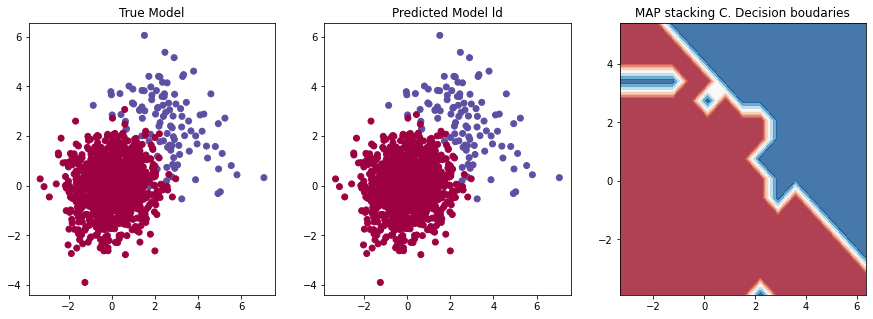

In [68]:
plt.figure(figsize=(15,5))
plt.subplot(132)
plt.scatter(X[:,0],X[:,1],c = stackfit.predict(X[:,0:2]),cmap = 'Spectral')
plt.title('Predicted Model ld')
plt.subplot(131)
plt.scatter(X[:,0],X[:,1],c = X[:,2],cmap = 'Spectral')
plt.title('True Model')
ax = plt.subplot(133)
ax.set_title('MAP stacking C. Decision boudaries')
tt = np.array(list(zip(list(x1Eval.flat),list(x2Eval.flat))))
Z = stackfit.predict(tt)
Z = Z.reshape(x1Eval.shape)
cm = plt.cm.RdBu
ax.contourf(x1Eval, x2Eval, Z, cmap=cm, alpha=.8);
#ax.scatter(x1Eval,x2Eval,c='gray',marker='x')
plt.show()